# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [37]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
try:
    import category_encoders as ce
except ModuleNotFoundError:
    !pip install -U category_encoders
    import category_encoders as ce

In [3]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

sns.set(rc={"figure.figsize": (12, 8)})

warnings.filterwarnings("ignore")

In [4]:
try:
    df_raw = pd.read_csv("./autos.csv")
except FileNotFoundError:
    df_raw = pd.read_csv("/datasets/autos.csv")

In [5]:
df_raw.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df_raw.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.0,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.0,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.0,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.0,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.0,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.0,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.0,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.0,99998.00


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных имеются пропуски, но это, очевидно, является неизбежным следствием неполноты данных о машинах как в учебной выборке, так и в будущих входных данных, на которых придётся работать моделям.

In [8]:
df_raw[df_raw.duplicated(keep=False)].sort_values(by="PostalCode")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57


В базе обнаружилось 4 дубля.

In [9]:
df = df_raw.drop_duplicates()

## Подготовка данных

Прежде всего, не все признаки имеют правильный тип. Так,  DateCrawled, DateCreated и LastSeen стоит преобразовать в datetime, а VehicleType, Gearbox, Model, FuelType, Brand и NotRepaired - в категориальные. Последний можно было сделать и булевым, но там присутствуют пропуски, так что возможных значений больше 2.

С другой стороны, не все регрессоры умеют работать с временными рядами, так что лучше преобразовать datetime в timestamp.

Полезным признаком видится возраст автомобиля на момент публикации анкеты.

In [10]:
df["DateCrawled"] = pd.to_datetime(df["DateCrawled"], format="%Y-%m-%d %H:%M:%S")

In [11]:
df["AgeYears"] = df["DateCrawled"].dt.year - df["RegistrationYear"]

Очевидно, что возраст автомобиля не может быть отрицательным

In [12]:
df[df["AgeYears"] < 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,AgeYears
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33,-2
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,-1
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44,-1
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08,-1
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02,-1
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27,-1
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04,-2
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13,-2


Видим 14,5 тысяч автомобилей для которых регистрация произошла позже даты скачивания анкеты. Это явная аномалия с неочевидным методом исправления. Поэтому просто удалим соответствующие записи 

In [13]:
df = df[df["AgeYears"] >= 0]

Такие признаки как дата выгрузки анкеты из базы, дата создания анкеты, дата активности пользователя и почтовый индекс владельца никак не характиризуют автомобиль. Возраст автомобиля с точностью до месяца врдли нужен, так что и колонка RegistrationMonth лишняя.

In [14]:
df = df.drop(
    [
        "DateCrawled",
        "DateCreated",
        "LastSeen",
        "PostalCode",
        "NumberOfPictures",
        "RegistrationMonth",
    ],
    axis=1,
)

Посмотрим на такой признак как мощность автомобиля 

In [15]:
df[["Power"]].describe()

,Power
count,339835.00
mean,111.02
std,186.98
min,0.00
25%,69.00
50%,105.00
75%,143.00
max,20000.00


Видим, что есть записи с нулевой мощность и с запредельно большой мощностью в 20000 л.с. И это при том, что самые мощные из легковых автомобилей имеют двигатели менее 2000 л.с.

In [16]:
df[df["Power"] > 2000].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,AgeYears
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN,17
11039,0,sedan,1998,manual,10317,other,150000,petrol,fiat,no,18
19092,9750,wagon,2005,auto,2729,5er,150000,gasoline,bmw,no,11
25232,10900,bus,2009,manual,10520,caddy,150000,gasoline,volkswagen,no,7
33952,3740,small,2006,manual,6920,aygo,90000,NaN,toyota,no,10


Volkswagen lupo с двигателем 7515 л.с это очень сильно. Можно было бы предположить ошибку в единицах измерения, но исправления этих аномально больших значений не очевидно.

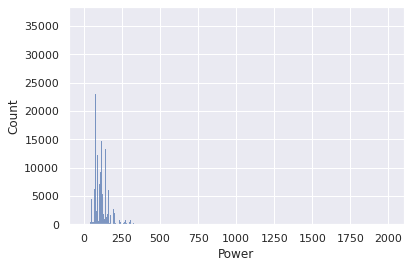

In [17]:
sns.histplot(data=df[df["Power"] < 2000], x="Power");

Мощный выброс виден в области значений мощности двигателя в 0 л.с., что явно невозможно. Избавимся от аномальных значений.

In [18]:
df = df[(df["Power"] > 0) & (df["Power"] < 2000)]

Так же посмотрим на год регистрации автомобилей:

In [19]:
df[["RegistrationYear"]].describe()

,RegistrationYear
count,303221.00
mean,2002.71
std,8.79
min,1000.00
25%,1999.00
50%,2003.00
75%,2007.00
max,2016.00


Явно в этом признаке также присутсвуют ошибки: в 1000 году, насколько известно, автомобили не производились. От ошибочных данных нужно избавиться. За одно отбросим и правильно заполненные, но очень старые автомобили, скажем, до 1960 года. Такие экземпляры редкость и оценивать их наравне с массовыми современными машинами некорректно. В принципе, можно сделать отсечку и по более поздней дате, тем более, что 25-процентная квартиль приходится га 1999 год.

In [20]:
df = df[df["RegistrationYear"] > 1960]

наконец, рассмотрим целевой признак - цену.

In [21]:
df[["Price"]].describe()

,Price
count,302976.00
mean,4748.23
std,4613.61
min,0.00
25%,1250.00
50%,3000.00
75%,6900.00
max,20000.00


Минимальная цена 0 - это не хорошо.

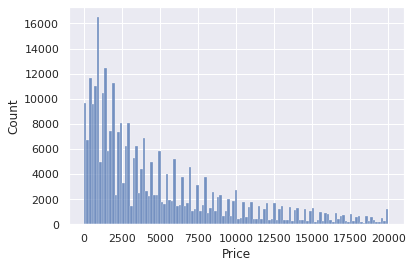

In [22]:
sns.histplot(data=df, x="Price");

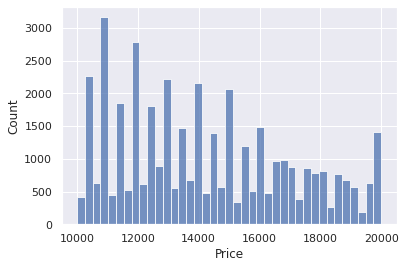

In [23]:
sns.histplot(data=df[df["Price"] > 10000], x="Price");

Максимальная цена в 20k выглядит как явный выброс: по ней много больше придлжений, чем по ближайшим ценам. Впрочем, это может быть связано с эффектом "круглого" числа. Это подтверждается ярко выраженными всплесками возле нескольких "круглых" значений

In [24]:
df = df[df["Price"] > 0]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296580 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296580 non-null  int64 
 1   VehicleType       285533 non-null  object
 2   RegistrationYear  296580 non-null  int64 
 3   Gearbox           291202 non-null  object
 4   Power             296580 non-null  int64 
 5   Model             285430 non-null  object
 6   Kilometer         296580 non-null  int64 
 7   FuelType          280990 non-null  object
 8   Brand             296580 non-null  object
 9   NotRepaired       253611 non-null  object
 10  AgeYears          296580 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 27.2+ MB


In [26]:
df[["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]] = df[
    ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]
].astype("category")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296580 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             296580 non-null  int64   
 1   VehicleType       285533 non-null  category
 2   RegistrationYear  296580 non-null  int64   
 3   Gearbox           291202 non-null  category
 4   Power             296580 non-null  int64   
 5   Model             285430 non-null  category
 6   Kilometer         296580 non-null  int64   
 7   FuelType          280990 non-null  category
 8   Brand             296580 non-null  category
 9   NotRepaired       253611 non-null  category
 10  AgeYears          296580 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 15.6 MB


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop("Price", axis=1), df["Price"], test_size=0.25
)

Помимо этого набора данных, нам придётся сделать второй, чисто числовой, поскольку многие модели не умеют работать с категориальными данными. 

Преобразуем категориальные значения в числовые c учётом того, что все категориальные признаки являются номинативными, т.е. не предполагают упорядочености.

In [29]:
df[["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]].nunique()

VehicleType      8
Gearbox          2
Model          249
FuelType         7
Brand           40
NotRepaired      2
dtype: int64

Как видно, большинство наших категориальных признаков имеет небольшую размерность. Для их кодирования можно использовать OHE. Исключени составляют Model и Brand. Для них используем HashingEncoder, который работает аналогично OHE, но благодаря хэшированию порождает меньше новых изменений. По умолчанию для кодирования используется 8 бит, чего хватит для кодирования 250 моделей.

In [30]:
df1 = df.copy()

In [31]:
df1 = pd.get_dummies(
    df1,
    columns=["VehicleType", "Gearbox", "FuelType", "NotRepaired"],
    prefix=["VehicleType", "Gearbox", "FuelType", "NotRepaired"],
    dummy_na=True,
)

In [32]:
%%time
df1 = ce.hashing.HashingEncoder(cols=["Model", "Brand"]).fit_transform(df1)

CPU times: user 131 ms, sys: 246 ms, total: 378 ms
Wall time: 1min 2s


In [33]:
df1.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Price,RegistrationYear,Power,Kilometer,AgeYears,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,VehicleType_nan,Gearbox_auto,Gearbox_manual,Gearbox_nan,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_nan,NotRepaired_no,NotRepaired_yes,NotRepaired_nan
1,2,0,0,0,0,0,0,0,18300,2011,190,125000,5,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,0,1,1,0,0,0,0,0,9800,2004,163,125000,12,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,1,1500,2001,75,150000,15,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,1,1,0,0,0,0,3600,2008,69,90000,8,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,0,0,0,0,1,1,0,0,650,1995,102,150000,21,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


В итоге мы упаковали 250х40 значений модель-бренд в 8 новых измерений. Платой за такую компактнойсть стало, в частности, время вычисления, которе для нашего не очень большого датасета составила почти минуту.

In [34]:
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    df1.drop("Price", axis=1), df1["Price"], test_size=0.2
)

Поскольку полного консенсуса по кодированию категориальных признаков нет, как альтернативу рассмотрим простое, но широко роаспространённое OrdinalEncoding и посмотрим, какой из методов покажет лучшие результаты на моделях на основе деревьев. Для линейной регрессии OrdinalEncoding не подойдёт.

In [40]:
df2 = df.copy()

In [41]:
oe = OrdinalEncoder()
df2[["VehicleType", "Gearbox", "FuelType", "NotRepaired", "Model", "Brand"]] = oe.fit_transform(
    df2[["VehicleType", "Gearbox", "FuelType", "NotRepaired", "Model", "Brand"]]
)
df2 = df2.fillna(-1)
df2.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,AgeYears
1,18300,2.0,2011,1.0,190,-1.0,125000,2.0,1.0,1.0,5
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,-1.0,12
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,15
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,8
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0,21


In [42]:
X2_train, X2_valid, y2_train, y2_valid = train_test_split(
    df2.drop("Price", axis=1), df2["Price"], test_size=0.2
)

## Обучение моделей

### Линейная регрессия

Начнём с самой просто й модели: линейной регрессии. Она не умеет работать с параметрами иных типов нежели числовые, так что приведём всё к вещественным и обучим модель

In [43]:
%%time
lr_model = LinearRegression(n_jobs=-1).fit(X1_train, y1_train)

CPU times: user 1.78 s, sys: 479 ms, total: 2.26 s
Wall time: 461 ms


In [44]:
%%time
mean_squared_error(y1_valid, lr_model.predict(X1_valid)) ** 0.5

CPU times: user 43.2 ms, sys: 37.3 ms, total: 80.5 ms
Wall time: 22.1 ms


2955.1185233138553

### Решающее дерево

Далее попробуем использовать регрессор на решающем дереве

In [50]:
dtr_model1 = DecisionTreeRegressor(random_state=42)

In [51]:
%%time
dtr_model1.fit(X1_train, y1_train)

CPU times: user 1.4 s, sys: 19.1 ms, total: 1.42 s
Wall time: 1.42 s


DecisionTreeRegressor(random_state=42)

In [52]:
%%time
mean_squared_error(y1_valid, dtr_model1.predict(X1_valid)) ** 0.5

CPU times: user 36 ms, sys: 375 µs, total: 36.4 ms
Wall time: 34.5 ms


1911.8985845210848

И тоже самое на `df2`

In [53]:
dtr_model2 = DecisionTreeRegressor(random_state=42)

In [54]:
%%time
dtr_model2.fit(X2_train, y2_train)

CPU times: user 769 ms, sys: 0 ns, total: 769 ms
Wall time: 768 ms


DecisionTreeRegressor(random_state=42)

In [55]:
%%time
mean_squared_error(y2_valid, dtr_model2.predict(X2_valid)) ** 0.5

CPU times: user 25.1 ms, sys: 3.73 ms, total: 28.8 ms
Wall time: 27.1 ms


1897.8440206294372

Время обучения на втором датафрейме (с OrdinalEncoder) уменьшилось вдвое, ошибка так же уменьшилась, но незначительно (меньше процента).

Поскольку дерево обучается быстро, можно подобрать гиперпараметры простым перебором по сетке: 

In [56]:
gs_dtr1 = GridSearchCV(
    estimator=dtr_model1,
    param_grid={
        "max_depth": range(2, 52 + 1, 10),
        "min_samples_split": range(2, 10 + 1, 2),
        "min_samples_leaf": range(1, 5 + 1),
    },
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

In [57]:
%%time
gs_dtr1.fit(X1_train, y1_train)

CPU times: user 4.06 s, sys: 1.14 s, total: 5.21 s
Wall time: 2min 22s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 53, 10),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 11, 2)},
             scoring='neg_root_mean_squared_error')

In [58]:
%%time
mean_squared_error(y1_valid, gs_dtr1.best_estimator_.predict(X1_valid)) ** 0.5

CPU times: user 25.3 ms, sys: 8.18 ms, total: 33.5 ms
Wall time: 31.2 ms


1755.073491908329

In [59]:
gs_dtr2 = GridSearchCV(
    estimator=dtr_model2,
    param_grid={
        "max_depth": range(2, 52 + 1, 10),
        "min_samples_split": range(2, 10 + 1, 2),
        "min_samples_leaf": range(1, 5 + 1),
    },
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

In [60]:
%%time
gs_dtr2.fit(X2_train, y2_train)

CPU times: user 2.94 s, sys: 919 ms, total: 3.85 s
Wall time: 1min 3s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 53, 10),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 11, 2)},
             scoring='neg_root_mean_squared_error')

In [61]:
%%time
mean_squared_error(y2_valid, gs_dtr2.best_estimator_.predict(X2_valid)) ** 0.5

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 18.3 ms


1723.6206663125454

После подбора гиперпараметров решающего дерева, результаты датафреймов с разными методами кодирования также отличаются незначительно. Уменьшение времени обучения примерно вдвое при переходе на OrdinalEncoder на лицо.

### Случайный лес

Следующий класс моделей &mdash; случайный лес. Для начала в дефолтных настройках

In [62]:
rfr_model1 = RandomForestRegressor(n_jobs=-1, random_state=42)

In [63]:
%%time
rfr_model1.fit(X1_train, y1_train)

CPU times: user 4min 17s, sys: 1.24 s, total: 4min 19s
Wall time: 34.5 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [64]:
%%time
mean_squared_error(y1_valid, rfr_model1.predict(X1_valid)) ** 0.5

CPU times: user 4.62 s, sys: 32.6 ms, total: 4.65 s
Wall time: 639 ms


1595.8231888779237

In [65]:
rfr_model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

In [66]:
%%time
rfr_model2.fit(X2_train, y2_train)

CPU times: user 1min 55s, sys: 706 ms, total: 1min 55s
Wall time: 15.2 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [67]:
%%time
mean_squared_error(y2_valid, rfr_model2.predict(X2_valid)) ** 0.5

CPU times: user 4.56 s, sys: 19.8 ms, total: 4.58 s
Wall time: 664 ms


1561.014690426967

Видно, что случайный лес показывает меньшую ошибку, чем отдельное дерево и тем более линейная регрессия. Платой за точность является существенно, на порядок, возросшее время на обучения модели и на прогнозирование. 

Что же касается методов кодирования категориальных переменных, то по скоорстим обучения вновь двухкратно лидирует ordinalEncoder, тогда как измение ошибки находится в пределах 2%. В целом, можно сделать вывод, что на моделях, основанных на деревьях простой и быстрый OrdinalEncoder действительно имеет приемущество: если точность предсказаний почти не меняется, то время обучения снижается значительно. А если нет разницы...?

### Градиентный бустинг

Наконец, посмотрим, что нам даст применение градиентного бустинга. Используем модуль `LightGBM`, Опять же, начнём со значений по умолчанию:

In [46]:
lgr_model = LGBMRegressor(random_state=42, n_jobs=-1)

In [47]:
%%time
lgr_model.fit(X_train, y_train)

In [48]:
%%time
mean_squared_error(y_valid, lgr_model.predict(X_valid)) ** 0.5

Что тут интересно. Ошибка прогнозирования LightGBM со значениями по умолчанию сравнима с аналогичной моделью случайного леса, но скорость работы существенно выше и сравнима с одиночным решающим деревом

Попробуем улучшить результаты LightGBM за счёт оптимизации гиперпараметров. Наиболее перспективными представляются следующие: `n_estimators`, `max_depth`, `num_leaves`, `min_split_gain` и `min_child_weight`. На одной машине без мощной видеокарты нам вряд ли удастся перебрать все перспективные значения параметров, так что попробуем как и в прошлые разы использовать случайный поиск, чтобы выявить наиболее важные признаки и сузить круг поиска оптимума. 

In [55]:
param_dist = {
    "n_estimators": [int(x) for x in np.linspace(start=20, stop=300, num=20)],
    "max_depth": [int(x) for x in np.linspace(start=5, stop=50, num=10)],
    "min_split_gain": [0.01, 0.1, 1, 2, 10],
    "min_child_weight": [int(x) for x in np.linspace(start=25, stop=150, num=15)],
}
rs_lgr = RandomizedSearchCV(
    lgr_model,
    param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

In [56]:
%%time
rs_lgr.fit(X_train, y_train)
rs_lgr.best_params_

In [57]:
rs_lgr_df = (
    pd.DataFrame(rs_lgr.cv_results_)
    .sort_values("rank_test_score")
    .reset_index(drop=True)
)
rs_lgr_df = rs_lgr_df.drop(
    [
        "mean_fit_time",
        "std_fit_time",
        "mean_score_time",
        "std_score_time",
        "params",
        "split0_test_score",
        "split1_test_score",
        "std_test_score",
    ],
    axis=1,
)

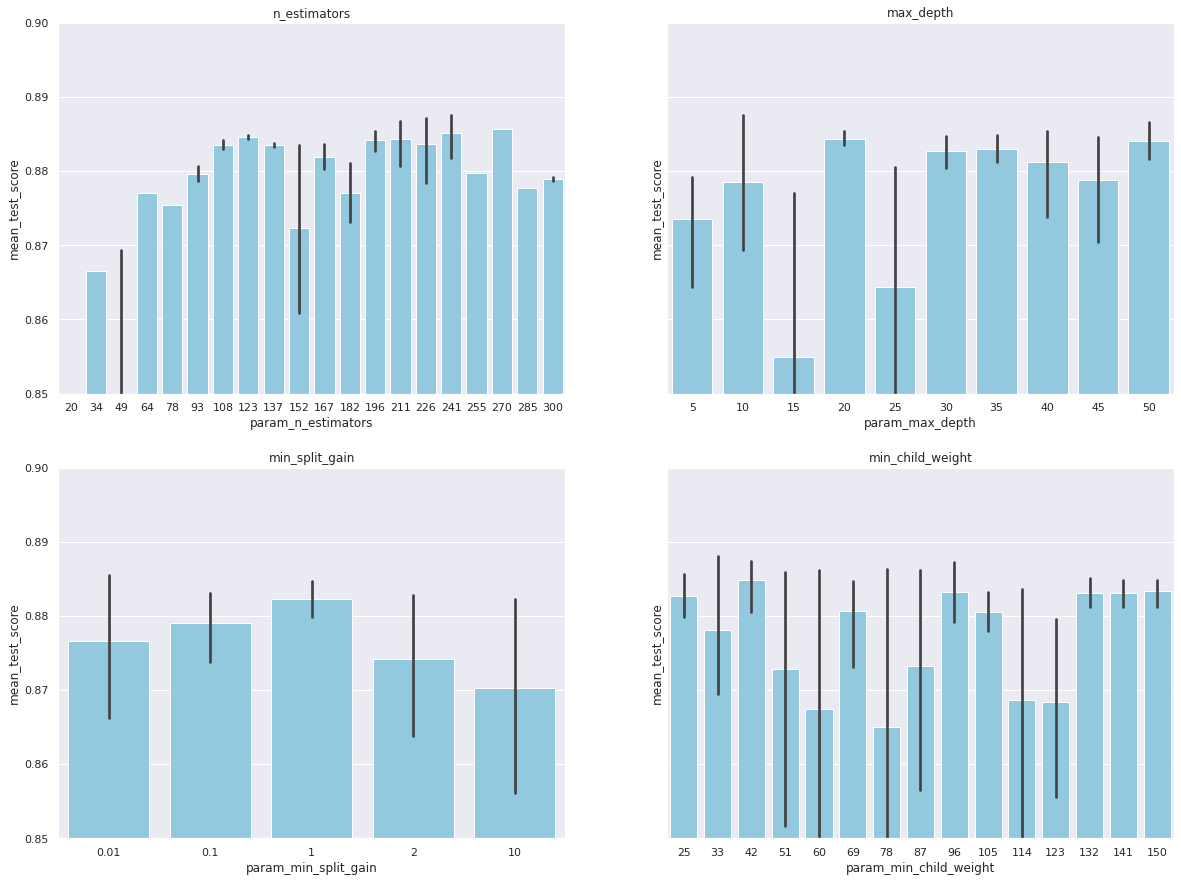

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharey=True)
sns.barplot(
    x="param_n_estimators",
    y="mean_test_score",
    data=rs_lgr_df,
    ax=axs[0, 0],
    color="skyblue",
)
axs[0, 0].set_ylim([0.85, 0.9])
axs[0, 0].set_title(label="n_estimators")
sns.barplot(
    x="param_max_depth",
    y="mean_test_score",
    data=rs_lgr_df,
    ax=axs[0, 1],
    color="skyblue",
)
axs[0, 1].set_title(label="max_depth")
sns.barplot(
    x="param_min_split_gain",
    y="mean_test_score",
    data=rs_lgr_df,
    ax=axs[1, 0],
    color="skyblue",
)
axs[1, 0].set_title(label="min_split_gain")

sns.barplot(
    x="param_min_child_weight",
    y="mean_test_score",
    data=rs_lgr_df,
    ax=axs[1, 1],
    color="skyblue",
)
axs[1, 1].set_title(label="min_child_weight");

In [60]:
gs_lgr = GridSearchCV(
    estimator=lgr_model,
    param_grid={
        "n_estimators": [110, 115, 120, 125, 130],
        "max_depth": [18, 20, 22, 50, 55],
        "min_split_gain": [1],
        "min_child_weight": [60],
    },
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

In [61]:
%%time
gs_lgr.fit(X_train, y_train)

In [62]:
%%time
mean_squared_error(y_valid, gs_lgr.best_estimator_.predict(X_valid)) ** 0.5

## Анализ моделей

Перейдём к анализу исследованных моделей. Все выводы будем делать в рамках заданного бизнесом критерия качества работы молелеё цены: минимизации средне-квадратичной ошибки.

### Линейная регрессия

Эта достаточно простая модель, как и следовало ожидать, показала чрезвычайно высокую скорость обучения и работы (единицы микросекунд) при весьма посредственном качестве прогноза: средне-квадратичная ошибка оказалась в районе 4000 (долларов?) при медианной цене в выборке 2700.

### Решающее дерево

Одиночное решающее дерево также показало довольно высокую скорость обучения (порядка 3с) и работы (около ста микросекунд). Качество её работы оказалось ощутимо лучше линейной регрессии: после тюнинга среднеквадратичная ошибка составила 2000.

### Случайный лес

Ансамбль из решающих деревьев продемонстрировал умеренный прирост точности прогноза до 1700, но ценой значительного роста времени как обучения (), так и прогнозирования ().

### Градиентный бустинг

Библиотека градиентного бустинга показала качество прогноза сравнимое со случайным лесом: около 1700, что не удивительно, поскольку в основе LGBM лежит случайный лес. При этом скорость обучения и прогнозирования оказались на уровне одиночного решающего дереве: порядка 1 секунды и 200 мс, соответственно.

In [63]:
results = pd.DataFrame(
    {
        "model": ["LR", "DT", "RF", "GBM"],
        "fitting": [0.468, 1.42, 33.4, 0.723],
        "prediction": [0.017, 0.022, 0.646, 0.2],
        "RMSE": [2936, 1809, 1629, 1583],
    }
)

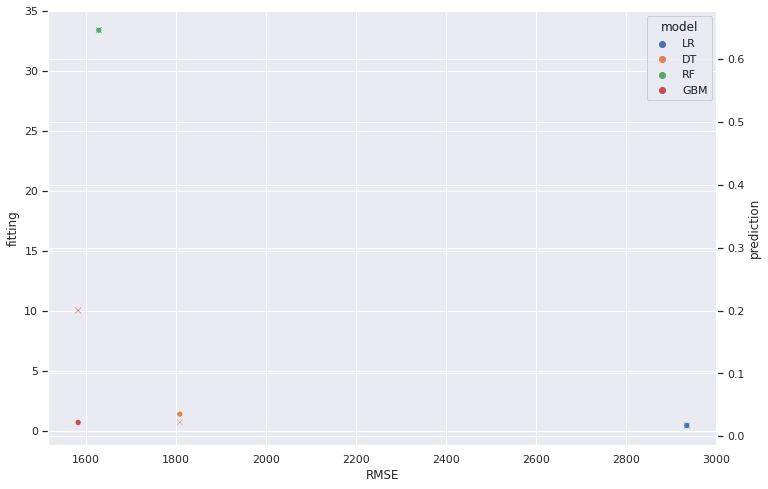

In [66]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
sns.scatterplot(ax=ax1, data=results, x="RMSE", y="fitting", hue="model", marker="o")
sns.scatterplot(ax=ax2, data=results, x="RMSE", y="prediction", hue="model", marker="x");

Видно, что в самом низу графика засположены линейная регрессия и решающее дерево. При этом они и праввее конкурентов, поскольку демонстрируют большую средне-квадратичную ошибку. С другой стороны, красные маркеры градиентного бустинга ближе всех к началу координат: эта модель демонстрирует и скорость и точность. 

# Вывод

Библиотека градиентного бустинга LightGBM показала себя отлично оптимизированным регрессором на основе слкчайного леса, который сочетает в себе высокую точность прогноза с высокой скоростью прогноза.

В ходе исследование было проведено сравнение двух разных методов кодирования каиегориальных переменных: OHE(на кактенгориях малой размернойсти) + Hashing (на категориях большой размерности) и OrdinalEncoder. В результате были получены очень близкие значения среднеквадратичных ошибок предсказания, но время обучения при OrdinalEncoder оказалось в два раза меньше. 

## Заметки

В качестве дополнительных направлений исследования можно было бы рассмотреть, как другие критерии (кажется, что тут был бы уместен коэффициент детеминации $R^2$), так и другие параметры модели. Так, помимо времени вычислений, интересно изучить расход памяти. Известно, что отличные скоростные характеристики показывают оптимизации, активно использующие кеширование в память, расплачиваясь за рост производительности расходом памяти. А это может стать ограничивающим фактором в ряде приложений.   